# Задача 3. Сравнение методов классификации

* **Дедлайн**: 19.11.2023, 23:59
* **Основной полный балл**: 5
* **Максимум баллов**: 10

## Задача

- [x] Самостоятельно реализовать один из методов классификации, с возможностью настройки гиперпараметров.
- [x] Взять данные для предсказания заболеваний сердца [тут](https://github.com/rustam-azimov/ml-course/tree/main/data/heart_disease) (целевой признак для предсказания --- **target**). Демо блокнот с анализом этих данных можно найти [тут](https://github.com/rustam-azimov/ml-course/blob/main/practice/practice07_knn_nb/practice07_part02_classification_heart_disease_demo.ipynb).
- [x] Считать данные, выполнить первичный анализ данных, при необходимости произвести чистку данных (**Data Cleaning**).
- [x] Выполнить разведочный анализ (**EDA**), использовать визуализацию, сделать выводы, которые могут быть полезны при дальнейшем решении задачи классификации.
- [x] При необходимости выполнить полезные преобразования данных (например, трансформировать категариальные признаки в количественные), убрать ненужные признаки, создать новые (**Feature Engineering**).
- [x] Используя **подбор гиперпараметров**, **кросс-валидацию** и при необходимости **масштабирование данных**, добиться наилучшего качества предсказания от Вашей реализации на выделенной заранее тестовой выборке.
- [x] Повторить предыдущий пункт для библиотечных реализаций (например, из **sklearn**) всех пройденных методов классификации (**logistic regression, svm, knn, naive bayes, decision tree**).
- [x] Сравнить все обученные модели, построить их **confusion matrices**. Сделать выводы о полученных моделях в рамках решения задачи классификации на выбранных данных.
- [ ] * (**+2 балла**) Реализовать еще один из методов классификации и добавить его в сравнение.
- [ ] * (**+3 балла**) Найти данные, на которых интересно будет решать задачу классификации. Повторить все пункты задания на новых данных.

In [288]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, RepeatedStratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from scipy.stats import norm
from sklearn.naive_bayes import GaussianNB
from sklearn.utils.multiclass import unique_labels
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.validation import check_X_y, check_array, check_is_fitted

# Датасет

## Описание датасета:

Описание датасета:

* age - age in years
* sex - (1 = male; 0 = female)
* cp - chest pain type
* trestbps - resting blood pressure (in mm Hg on admission to the hospital)
* chol - serum cholestoral in mg/dl
* fbs - (fasting blood sugar > 120 mg/dl) (1 = true; 0 = false)
* restecg - resting electrocardiographic results
* thalach - maximum heart rate achieved
* exang - exercise induced angina (1 = yes; 0 = no)
* oldpeak - ST depression induced by exercise relative to rest
* slope - the slope of the peak exercise ST segment
* ca - number of major vessels (0-3) colored by flourosopy
* thal - 3 = normal; 6 = fixed defect; 7 = reversable defect
* target - have disease or not (1=yes, 0=no)

Необходимо решить задачу классификации и научиться предсказывать целовой признак **target** имеет ли пациент заболевание сердца.

In [289]:
df = pd.read_csv('heart.csv')
df.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,52,1,0,125,212,0,1,168,0,1.0,2,2,3,0
1,53,1,0,140,203,1,0,155,1,3.1,0,0,3,0
2,70,1,0,145,174,0,1,125,1,2.6,0,0,3,0
3,61,1,0,148,203,0,1,161,0,0.0,2,1,3,0
4,62,0,0,138,294,1,1,106,0,1.9,1,3,2,0


# EDA

In [290]:
df.isnull().sum()

age         0
sex         0
cp          0
trestbps    0
chol        0
fbs         0
restecg     0
thalach     0
exang       0
oldpeak     0
slope       0
ca          0
thal        0
target      0
dtype: int64

Пропущенных значений нет

In [291]:
df.describe(include='all')

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,1025.000000,1025.000000,1025.000000,1025.000000,1025.00000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000,1025.000000
mean,54.434146,0.695610,0.942439,131.611707,246.00000,0.149268,0.529756,149.114146,0.336585,1.071512,1.385366,0.754146,2.323902,0.513171
std,9.072290,0.460373,1.029641,17.516718,51.59251,0.356527,0.527878,23.005724,0.472772,1.175053,0.617755,1.030798,0.620660,0.500070
min,29.000000,0.000000,0.000000,94.000000,126.00000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,48.000000,0.000000,0.000000,120.000000,211.00000,0.000000,0.000000,132.000000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,56.000000,1.000000,1.000000,130.000000,240.00000,0.000000,1.000000,152.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,275.00000,0.000000,1.000000,166.000000,1.000000,1.800000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.00000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


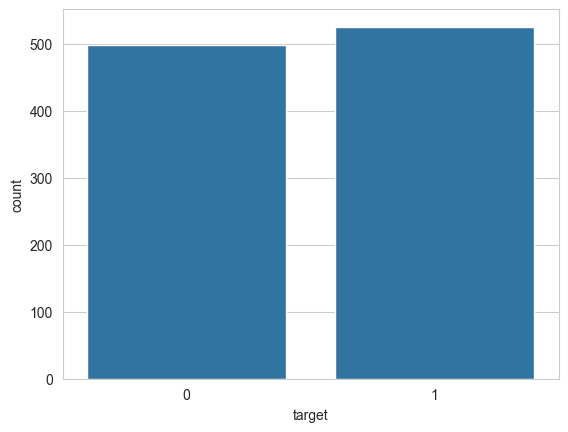

In [292]:
sns.countplot(x="target", data=df)
plt.show()

Видим, что датасет сбалансирован

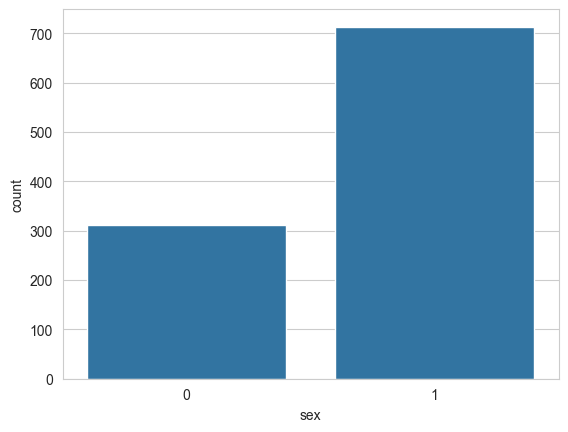

In [293]:
sns.countplot(x="sex", data=df)
plt.show()

Видим, что по большей части датасет состоит из мужчин

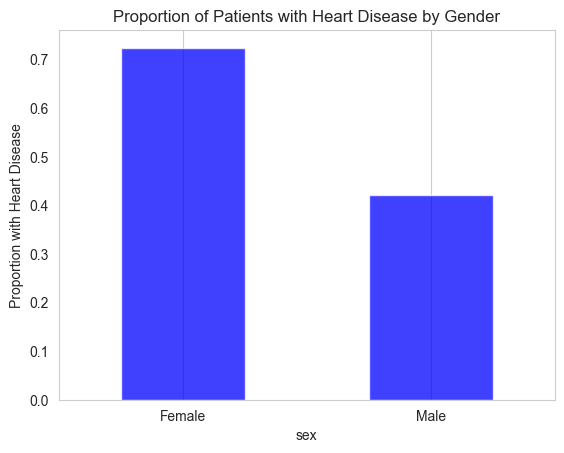

In [294]:
grouped_by_sex = df.groupby('sex')
counts_by_sex = grouped_by_sex['target'].agg(total_count='count', total_sick=lambda x: (x == 1).sum())
counts_by_sex['proportion_sick'] = counts_by_sex['total_sick'] / counts_by_sex['total_count']
bar_plot = counts_by_sex['proportion_sick'].plot.bar(color='blue', alpha=0.75)
plt.xticks([0, 1], ['Female', 'Male'], rotation=0)
plt.xlabel('sex')
plt.ylabel('Proportion with Heart Disease')
plt.title('Proportion of Patients with Heart Disease by Gender')
plt.grid(axis='y')
plt.show()

Несмотря на это, у женщин заболевание встречается чаще

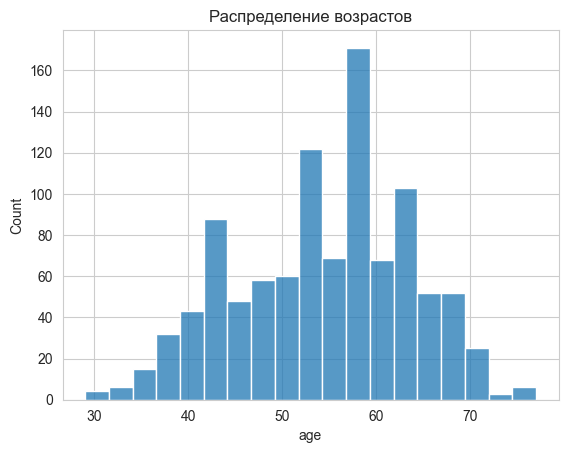

In [295]:
plt.figure()
sns.histplot(df["age"])
plt.title("Распределение возрастов")
plt.show()

Видим, что датасет по большей части состоит из информации по людям возрастом 40--70 лет

Посмотрим для каждого возраста, насколько часты сердечные заболевания у людей этого возраста

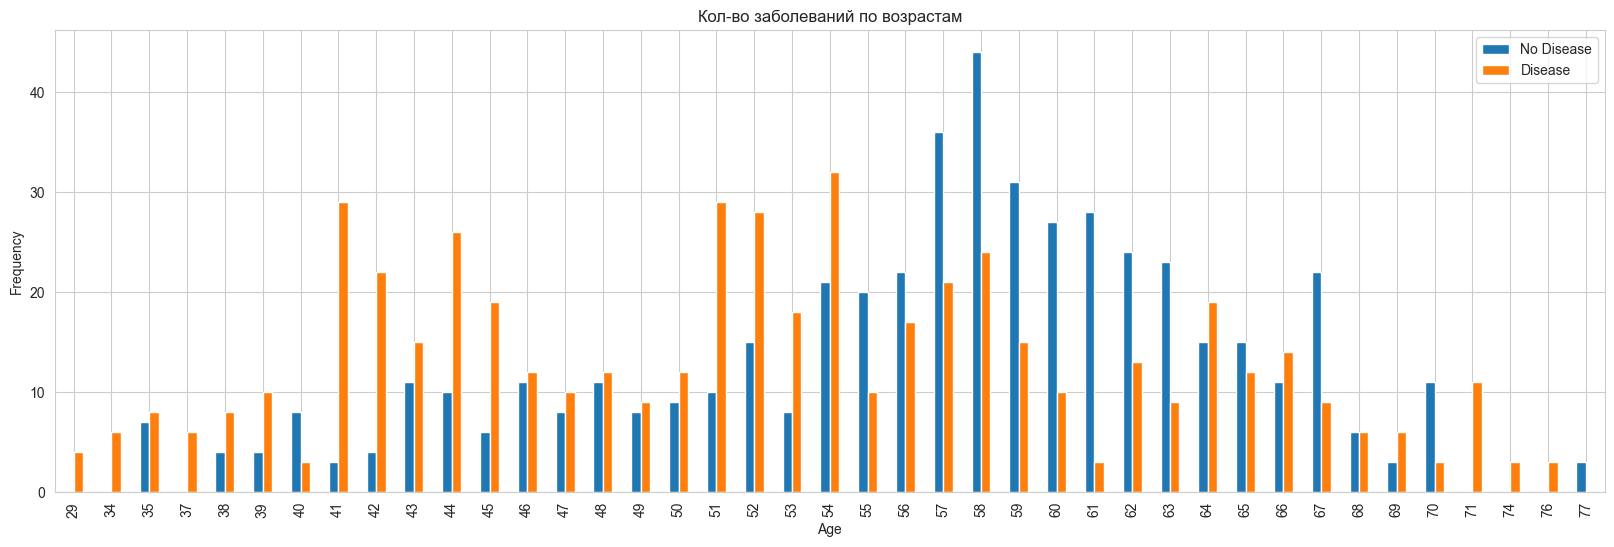

In [296]:
pd.crosstab(df.age,df.target).plot(kind="bar",figsize=(20,6))
plt.title('Кол-во заболеваний по возрастам')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.legend(["No Disease", "Disease"])
plt.show()

Видим существенную разницу: в возрастах 41-45 лет сердечные заболевания случаются значительно чаще нежели в возрастах 55-63 лет

Посмотрим зависмость уровеня холестерина и макс частоты сердечных сокращений у больных и здоровых людей.

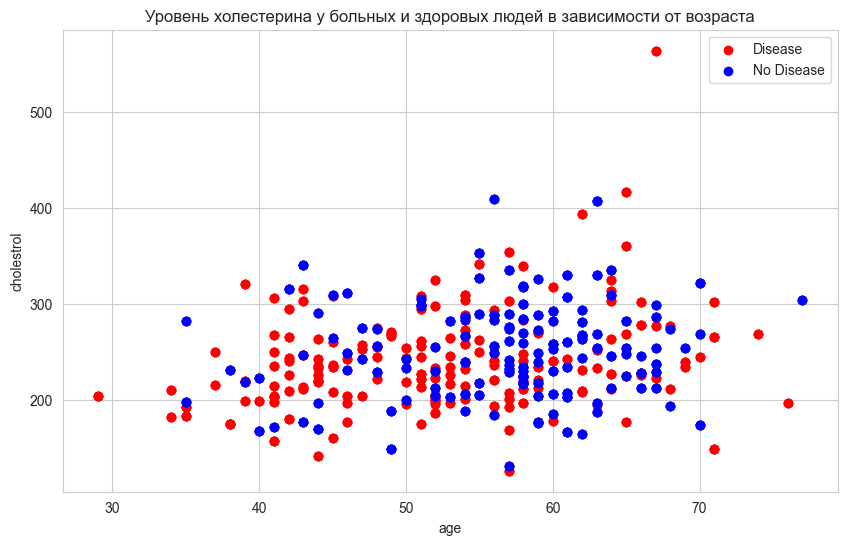

In [297]:
plt.figure(figsize = (10,6))

plt.scatter(df.age[df.target == 1], df.chol[df.target ==1], color = "red")
plt.scatter(df.age[df.target==0], df.chol[df.target==0], color = "blue")

plt.xlabel("age")
plt.ylabel("cholestrol")
plt.legend(["Disease", "No Disease"])
plt.title("Уровень холестерина у больных и здоровых людей в зависимости от возраста")
plt.xticks(rotation = 0);

У возрастов 40-50 лет у больных людей уровень холестерина обычно выше нежели у здоровых людей.

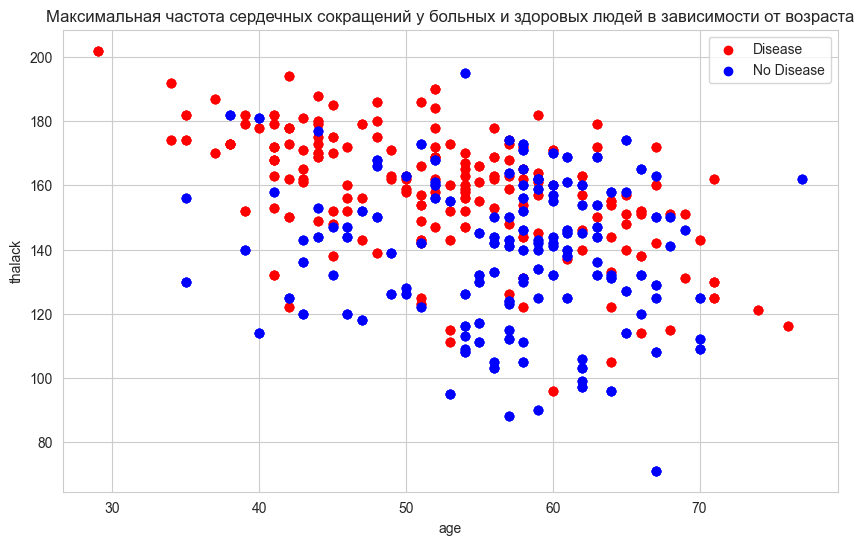

In [298]:
plt.figure(figsize = (10,6))

plt.scatter(df.age[df.target == 1], df.thalach[df.target ==1], color = "red")
plt.scatter(df.age[df.target==0], df.thalach[df.target==0], color = "blue")

plt.xlabel("age")
plt.ylabel("thalack")
plt.legend(["Disease", "No Disease"])
plt.title("Максимальная частота сердечных сокращений у больных и здоровых людей в зависимости от возраста")
plt.xticks(rotation = 0);

Здесь уже явно заметно, что почти для всех возрастов у больных людей была зафиксирована бОльшая частота сердечных сокращений нежели у здоровых людей.

Посмотрим, меняется ли частота заболеваний в зависимости от типа боли в груди

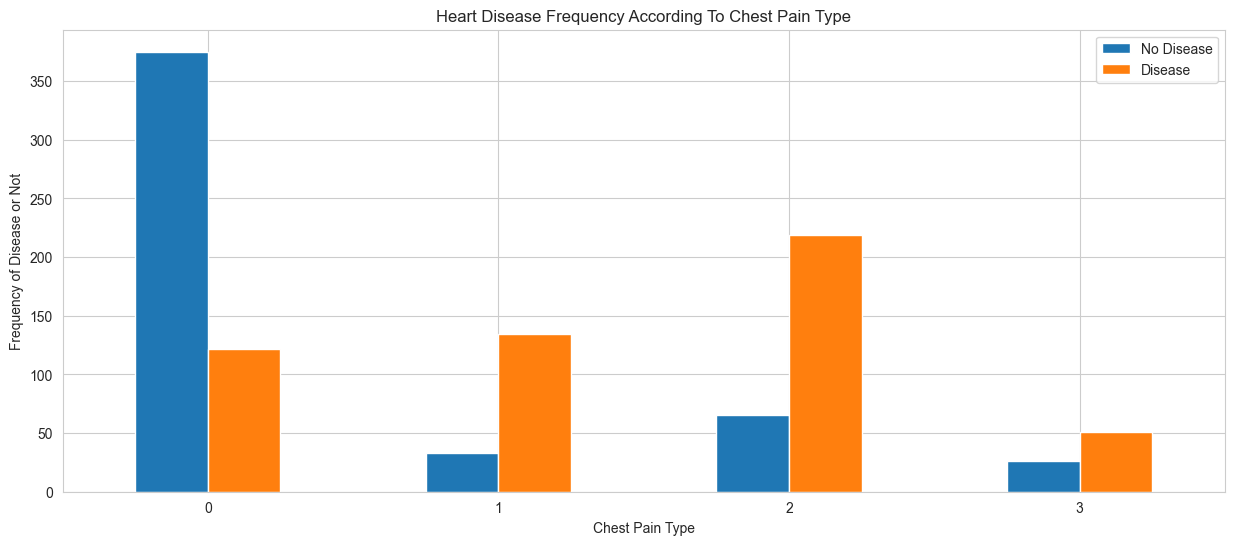

In [299]:
pd.crosstab(df.cp,df.target).plot(kind="bar",figsize=(15,6))
plt.title('Heart Disease Frequency According To Chest Pain Type')
plt.xlabel('Chest Pain Type')
plt.xticks(rotation = 0)
plt.legend(["No Disease", "Disease"])
plt.ylabel('Frequency of Disease or Not')
plt.show()

Видим, что самые "опасные" типы боли: 1 и 2, поскольку доля больных людей с такими типами боли значительно больше, чем у 0 и 3 типа

Посмотрим на корреляционную матрицу

<Axes: >

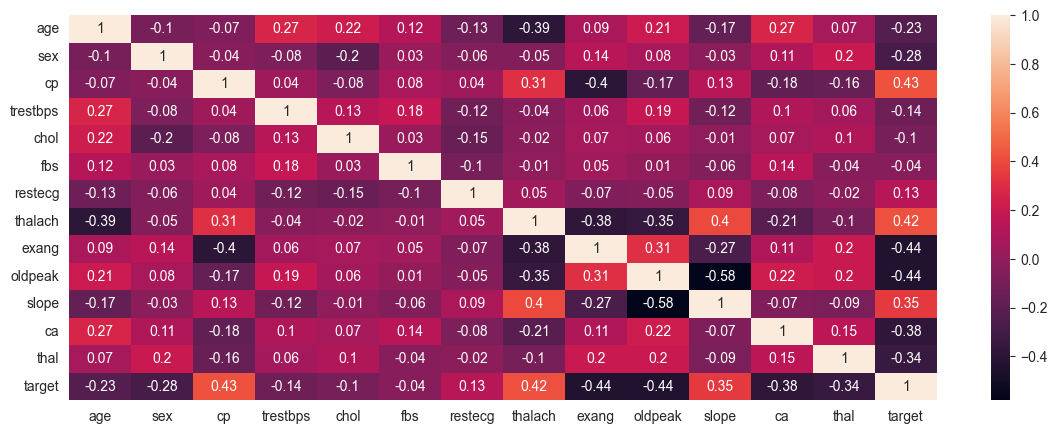

In [300]:
plt.figure(figsize = (14,5))
sns.heatmap(round(df.corr(),2),annot=True)

Видим, что существуют значительные как положительные, так и отрицательные корреляции между целевым признаком и остальными как cp, thalach, slope и другими

# Реализация метода опорных векторов

In [301]:
class SVMClassifier(BaseEstimator, ClassifierMixin):
    def __init__(self, learning_rate=0.001, iter_num=10000, lmda=0.01):
        self.learning_rate = learning_rate
        self.iter_num = iter_num
        self.lmda = lmda


    def fit(self, X, y):
        X, y = check_X_y(X, y)

        self._classes = unique_labels(y)
        self.X_ = X
        self.y_ = y
        for i in range(self.iter_num):
            self._update_weights()
        return self

    def _update_weights(self):
        n = self.X_.shape[1]
        self.w = np.zeros(n)
        self.b = 0
        y_label = np.where(self.y_ <= 0, -1, 1)
        for index, x_i in enumerate(self.X_):
            if y_label[index] * (np.dot(x_i, self.w) - self.b) >= 1:
                dw = 2 * self.lmda * self.w
                db = 0
            else:
                dw = 2 * self.lmda * self.w - np.dot(x_i, y_label[index])
                db = y_label[index]
            self.w = self.w - self.learning_rate * dw
            self.b = self.b - self.learning_rate * db

    def predict(self, X):
        check_is_fitted(self)
        X = check_array(X)
        output = np.dot(X, self.w) - self.b
        predicted_labels = np.sign(output)
        y_hat = np.where(predicted_labels <= -1, 0, 1)
        return y_hat

    def get_params(self, deep=True):
        return {"learning_rate": self.learning_rate, "iter_num": self.iter_num, "lmda": self.lmda}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

## Разделение выборки

In [247]:
x = df.drop(['target'], axis=1)
y = df['target']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

## Масштабирование

In [248]:
scaler = StandardScaler()
x_train = pd.DataFrame(scaler.fit_transform(x_train), columns=x.columns)
x_test = pd.DataFrame(scaler.transform(x_test), columns=x.columns)
x_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
0,-0.585840,0.654654,1.008275,-0.779454,-1.935031,-0.414039,-0.983742,-1.019094,-0.725949,-0.210661,1.005264,2.171691,-0.545193
1,1.051477,-1.527525,-0.916720,2.741732,1.610634,-0.414039,0.909846,0.202882,1.377507,-0.912152,1.005264,-0.725467,-0.545193
2,-0.040068,-1.527525,1.008275,-1.347387,0.442176,-0.414039,-0.983742,0.770228,-0.725949,-0.912152,1.005264,-0.725467,-0.545193
3,0.505705,0.654654,-0.916720,0.186033,-0.222636,-0.414039,0.909846,0.508376,-0.725949,-0.473720,-0.640079,-0.725467,1.110579
4,-0.367531,0.654654,1.008275,-0.381900,-0.001032,2.415229,-0.983742,0.726586,-0.725949,1.192321,-0.640079,-0.725467,-0.545193


## Подбор наилучших признаков

In [249]:
rfecv = RFECV(estimator=LogisticRegression())
rfecv.fit(x_train, y_train)
features = list(x_train.columns[rfecv.support_])

print("Оптимальное число признаков: ", rfecv.n_features_)
print("Оптимальные признаки: ", features)

Оптимальное число признаков:  11
Оптимальные признаки:  ['sex', 'cp', 'trestbps', 'chol', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']


 Избавимся от ненужных признаков

In [168]:
x_train = x_train[features]
x_test = x_test[features]
x_train.head()

,sex,cp,trestbps,chol,restecg,thalach,exang,oldpeak,slope,ca,thal
0,0.654654,1.008275,-0.779454,-1.935031,-0.983742,-1.019094,-0.725949,-0.210661,1.005264,2.171691,-0.545193
1,-1.527525,-0.916720,2.741732,1.610634,0.909846,0.202882,1.377507,-0.912152,1.005264,-0.725467,-0.545193
2,-1.527525,1.008275,-1.347387,0.442176,-0.983742,0.770228,-0.725949,-0.912152,1.005264,-0.725467,-0.545193
3,0.654654,-0.916720,0.186033,-0.222636,0.909846,0.508376,-0.725949,-0.473720,-0.640079,-0.725467,1.110579
4,0.654654,1.008275,-0.381900,-0.001032,-0.983742,0.726586,-0.725949,1.192321,-0.640079,-0.725467,-0.545193


# Подбор гиперпараметров

In [169]:
def print_best(gscv):
    print("best estimator: " + str(gscv.best_estimator_))
    print("best params: " + str(gscv.best_params_))
    print('best score:', gscv.best_score_)

## SVMClassifier - моя реализация

In [173]:
learning_rate_grid = [0.1, 0.001, 0.0005]
iter_num_grid = [100, 1000, 3000]
lmda_grid = [0.1, 0.001, 0.0005]

gscv = GridSearchCV(SVMClassifier(),
                        [{"learning_rate": learning_rate_grid, "iter_num": iter_num_grid, "lmda": lmda_grid}],
                        cv=StratifiedKFold(5), verbose=5, n_jobs=-1)
gscv.fit(x_train, y_train)
print_best(gscv)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
best estimator: SVMClassifier(iter_num=100, lmda=0.001)
best params: {'iter_num': 100, 'learning_rate': 0.001, 'lmda': 0.001}
best score: 0.8573170731707316


## NBClassifier - моя реализация

In [245]:
priors_grid = [None, [0.62, 0.38], [0.5, 0.5]]
alpha_grid = np.logspace(0, -9, num=50)

gscv = GridSearchCV(NBClassifier(),
                        [{"priors": priors_grid, "alpha": alpha_grid}],
                        cv=StratifiedKFold(5), verbose=5, n_jobs=-1)
gscv.fit(x_train.to_numpy(), y_train.to_numpy())
print_best(gscv)

Fitting 5 folds for each of 150 candidates, totalling 750 fits
best estimator: NBClassifier(alpha=1.0, priors=array([0.48414634, 0.51585366]))
best params: {'alpha': 1.0, 'priors': None}
best score: 0.5158536585365854


## LogisticRegression библиотечный

In [177]:
param_grid = {'C': np.arange(1e-05, 5, 0.1)}
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gscv = GridSearchCV(LogisticRegression(), return_train_score=True,
                  param_grid=param_grid, scoring=scoring, cv=StratifiedKFold(5), refit='Accuracy',
                   verbose=5, n_jobs=-1)
gscv.fit(x_train, y_train)
print_best(gscv)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
best estimator: LogisticRegression(C=2.7000100000000002)
best params: {'C': 2.7000100000000002}
best score: 0.8609756097560975


## SVM библиотечный

In [178]:
C = [0.1, 0.25, 0.5, 0.75, 1, 2]
kernel = ["linear", "rbf"]
gamma = ["scale", "auto", 0.0001, 0.001, 0.01, 0.1, 1]

gscv = GridSearchCV(estimator=SVC(random_state=11), cv=StratifiedKFold(5),
                        param_grid=dict(kernel=kernel,C=C, gamma=gamma),
                       verbose=5, n_jobs=-1)
gscv.fit(x_train, y_train)
print_best(gscv)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
best estimator: SVC(C=0.75, gamma=1, random_state=11)
best params: {'C': 0.75, 'gamma': 1, 'kernel': 'rbf'}
best score: 0.9719512195121951


## KNN библиотечный

In [180]:
n_neighbors = np.arange(1, 11, 2)
weights = ['uniform', 'distance']
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gscv = GridSearchCV(estimator=KNeighborsClassifier(), cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=12),
                       scoring=scoring, return_train_score=True,
                       param_grid=dict(n_neighbors=n_neighbors, weights=weights), refit='Accuracy',
                       verbose=5, n_jobs=-1)

gscv.fit(x_train, y_train)
print_best(gscv)

Fitting 25 folds for each of 10 candidates, totalling 250 fits
best estimator: KNeighborsClassifier(n_neighbors=7, weights='distance')
best params: {'n_neighbors': 7, 'weights': 'distance'}
best score: 0.9804878048780487


## Naive Bayes библиотечный

In [182]:
priors = [None, [0.62, 0.38], [0.5, 0.5]]
var_smoothing = np.logspace(0, -9, num=100)
scoring = {'Accuracy': 'accuracy', 'AUC': 'roc_auc', 'Log_loss': 'neg_log_loss'}

gscv = GridSearchCV(estimator=GaussianNB(), cv=RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=23),
                      scoring=scoring, return_train_score=True,
                      param_grid=dict(priors=priors, var_smoothing=var_smoothing), refit='Accuracy',
                      n_jobs=-1)

gscv.fit(x_train, y_train)
print_best(gscv)

best estimator: GaussianNB(priors=[0.62, 0.38], var_smoothing=0.657933224657568)
best params: {'priors': [0.62, 0.38], 'var_smoothing': 0.657933224657568}
best score: 0.8558536585365855


## Decision Tree библиотечный

In [184]:
criterion = ["gini", "entropy", "log_loss"]
splitter = ["best", "random"]
max_depth = [2, 3, 4, 5, 10, 20]
min_samples_split = [2, 4, 5, 10]
min_samples_leaf = [1, 2, 4, 6]
max_features = [2, 4, 6, 8]

gscv = GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), cv=StratifiedKFold(5),
                       param_grid=dict(criterion=criterion,splitter=splitter, max_depth=max_depth,
                                       min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,
                                       max_features= max_features), n_jobs=-1)
gscv.fit(x_train, y_train)
print_best(gscv)

best estimator: DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=4,
                       random_state=42, splitter='random')
best params: {'criterion': 'entropy', 'max_depth': 20, 'max_features': 4, 'min_samples_leaf': 1, 'min_samples_split': 2, 'splitter': 'random'}
best score: 0.9829268292682926


# Тестирование моделей

Запустим необходимые модели с подстановкой подобранных гиперпараметров

In [302]:
accuracies = {}

## SVMClassifier (собственная реализация)

In [303]:
my_svm = SVMClassifier(learning_rate=0.001, iter_num=100, lmda=0.001)
my_svm.fit(x_train.to_numpy(), y_train.to_numpy())
acc = my_svm.score(x_test, y_test)

accuracies['My SVM'] = acc
print("Test Accuracy of My SVM Algorithm: {:.4f}".format(acc))

Test Accuracy of My SVM Algorithm: 0.7707


## LogisticRegression (библиотечная реализация)

In [304]:
lr = LogisticRegression(C=2.7)
lr.fit(x_train, y_train)
acc = lr.score(x_test, y_test)

accuracies['Logistic Regression'] = acc
print("Test Accuracy {:.4f}".format(acc))

Test Accuracy 0.7951


## SVM (библиотечная реализация)

In [305]:
svm = SVC(C=0.75, gamma=1, kernel='rbf', random_state = 11)
svm.fit(x_train, y_train)

acc = svm.score(x_test, y_test)
accuracies['SVM'] = acc
print("Test Accuracy of SVM Algorithm: {:.4f}".format(acc))

Test Accuracy of SVM Algorithm: 0.9854


## KNN (библиотечная реализация)

In [309]:
knn = KNeighborsClassifier(n_neighbors=7, weights='distance')
knn.fit(x_train, y_train)

acc = knn.score(x_test, y_test)
accuracies['KNN'] = acc
print("Test Accuracy of SVM Algorithm: {:.4f}".format(acc))

Test Accuracy of SVM Algorithm: 1.0000


## Naive Bayes (библиотечная реализация)

In [310]:
nb = GaussianNB(priors=[0.62, 0.38], var_smoothing=0.657933224657568)
nb.fit(x_train, y_train)

acc = nb.score(x_test, y_test)
accuracies['Naive Bayes'] = acc
print("Accuracy of Naive Bayes: {:.4f}".format(acc))

Accuracy of Naive Bayes: 0.8000


## Decision Tree (библиотечная реализация)

In [311]:
dtc = DecisionTreeClassifier(criterion='entropy', max_depth=20, max_features=4, min_samples_leaf=1, min_samples_split=2, splitter='random')
dtc.fit(x_train, y_train)

acc = dtc.score(x_test, y_test)
accuracies['Decision Tree'] = acc
print("Decision Tree Test Accuracy {:.4f}".format(acc))

Decision Tree Test Accuracy 1.0000


## Сравнение моделей

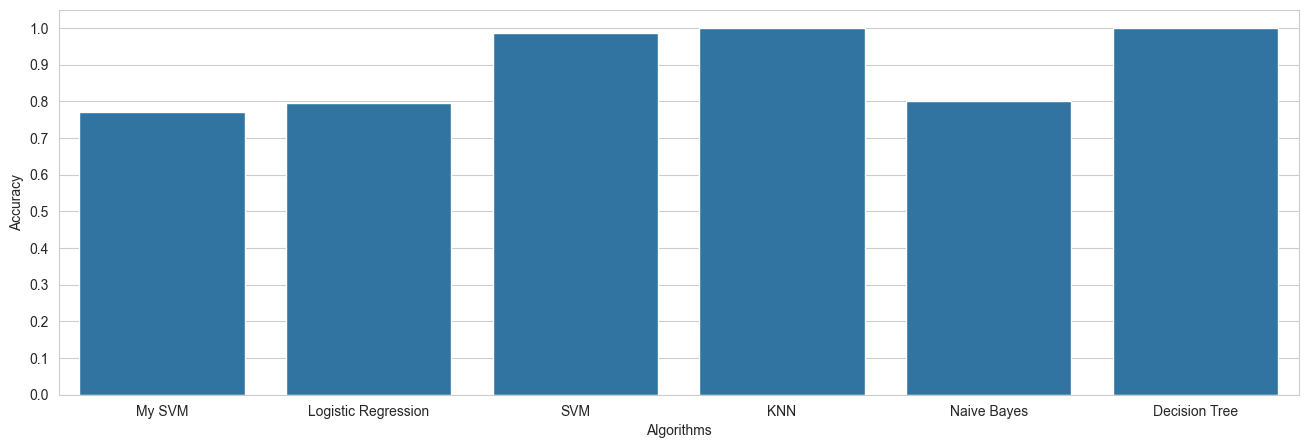

In [312]:
cs, accs = zip(*list(accuracies.items()))

sns.set_style("whitegrid")
plt.figure(figsize=(16, 5))
plt.yticks(np.arange(0, 1.1, 0.1))
plt.ylabel("Accuracy")
plt.xlabel("Algorithms")
sns.barplot(x=cs, y=accs)
plt.show()

Со значительным отрывом лидируют библиотечные реализации SVM, KNN и Decision Tree

# Confusion Matrix

In [326]:
def cm(cl):
    return confusion_matrix(y_test, cl.predict(x_test))

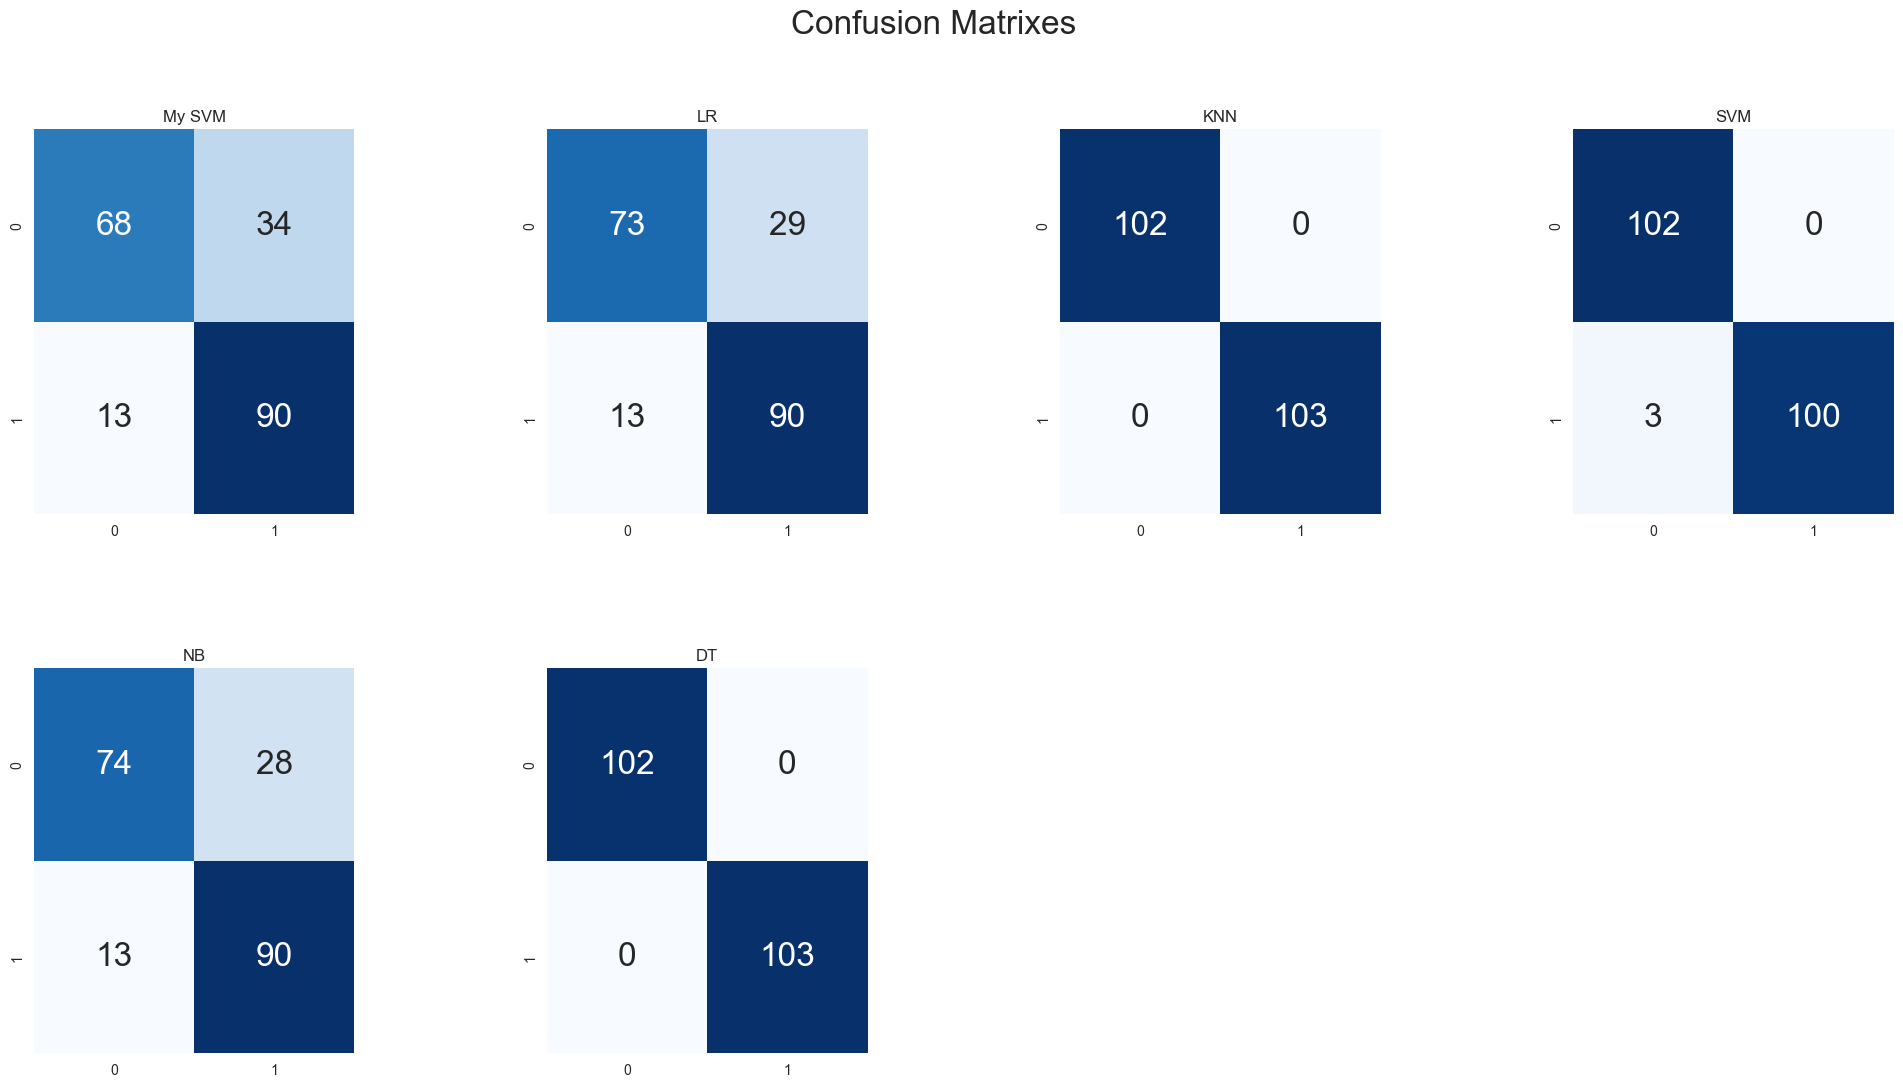

In [327]:
plt.figure(figsize=(24, 12))
plt.suptitle("Confusion Matrixes", fontsize=24)
plt.subplots_adjust(wspace = 0.6, hspace= 0.4)

for idx, (name, cm) in enumerate([
    ("My SVM", cm(my_svm)),
    ("LR", cm(lr)),
    ("KNN", cm(knn)),
    ("SVM", cm(svm)),
    ("NB", cm(nb)),
    ("DT", cm(dtc))
]):
    plt.subplot(2, 4, idx+1)
    plt.title(name)
    sns.heatmap(cm,annot=True,cmap="Blues",fmt="d",cbar=False, annot_kws={"size": 24})

plt.show()

# Выводы по первому датасету

- Лучшее качество показали модели SVM, KNN и Decision Tree
- Собственная реализация SVM уступает по качеству библиотечной, но тем не менее показывает качество на уровне библиотечных LR и NB